In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
# example of a dcgan on cifar10
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline
 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
 simps_dir = "/content/drive/My Drive/Data/DCGAN/"
 OUTPUT_DIR = "/content/drive/My Drive/Data/DCGAN/"

In [0]:
# define the standalone discriminator model
def discriminator_28(in_shape=(28,28,3)):
    print ('in discriminator')  
    print (in_shape)  
    
    model = Sequential()
    		 
    # downsample to 14x14  
    model.add(Conv2D(64,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())     
    
    # downsample to 7x7  
    model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())     

    # classifier
    model.add(Flatten())
    #model.add(Dropout(0.4))    
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model  

In [0]:
# define the standalone generator model
def generator_28(latent_dim):
    print ('in generator')  
    model = Sequential()
    n_nodes  = 64 * 7 * 7
    
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())     
    model.add(Reshape((7, 7, 64)))       
    
    # upsample to 14x14
    model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization()) 
    

    # upsample to 28x28  
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization()) 
    
    # output layer 32*32*3  
    model.add(Conv2D(3, (3,3) , activation='tanh', padding='same'))
    return model

In [0]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False

    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
# load and prepare cifar10 training images
def load_real_samples_cifar10_test():
	# load cifar10 dataset
	(_, _), (testX, _) = load_data()
	# convert from unsigned ints to floats
	X = testX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [0]:
# load and prepare cifar10 training images
def load_real_samples_cifar10():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [0]:
# load and prepare simpson's training images
def load_real_samples_simps():
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 

In [0]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  save_plot(x_fake, epoch)  
  g_model.save(filename)

In [0]:

def draw_loss_chart(g_losses, d_losses_real,d_losses_fake, epoch):
    #print ('in loss plot')    
    fig, ax = plt.subplots()
    plt.plot(d_losses_real, label='Discriminator Real', alpha=0.6)
    plt.plot(d_losses_fake, label='Discriminator fake', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Loss at epoch " + str(epoch))
    plt.legend()
    #plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()

In [0]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=3):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n * n):
      # define subplot
      pyplot.subplot(n, n, 1 + i)
      # turn off axis
      pyplot.axis('off')
      # plot raw pixel data
      pyplot.imshow(examples[i])
  # save plot to file
  pyplot.show()

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=0, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d_loss_real = []
  d_loss_fake = []
  g_losses = []		 
  # manually enumerate epochs
  for i in tqdm(range(n_epochs)):
    #print ('epoch at: ', i+1)		
    # enumerate batches over the training set
    for j in range(bat_per_epo):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
     
        d_loss1, _ = d_model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
	         
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        d_loss_real.append(d_loss1)
        d_loss_fake.append(d_loss2)
        g_losses.append(g_loss)								
        #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
        #  (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)
        draw_loss_chart(g_losses,d_loss_real, d_loss_fake, i+1)				
 


in discriminator
(28, 28, 3)
in generator
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 3)         434051    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 82689     
Total params: 516,740
Trainable params: 509,828
Non-trainable params: 6,912
_________________________________________________________________


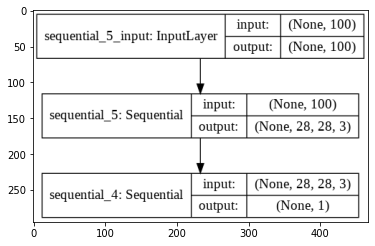

In [16]:
# create the discriminator  
d_model = discriminator_28()
# size of the latent space 100
latent_dim = 100   
# create the generator
g_model = generator_28(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('gan_plot.png')
plt.imshow(img)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1792      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

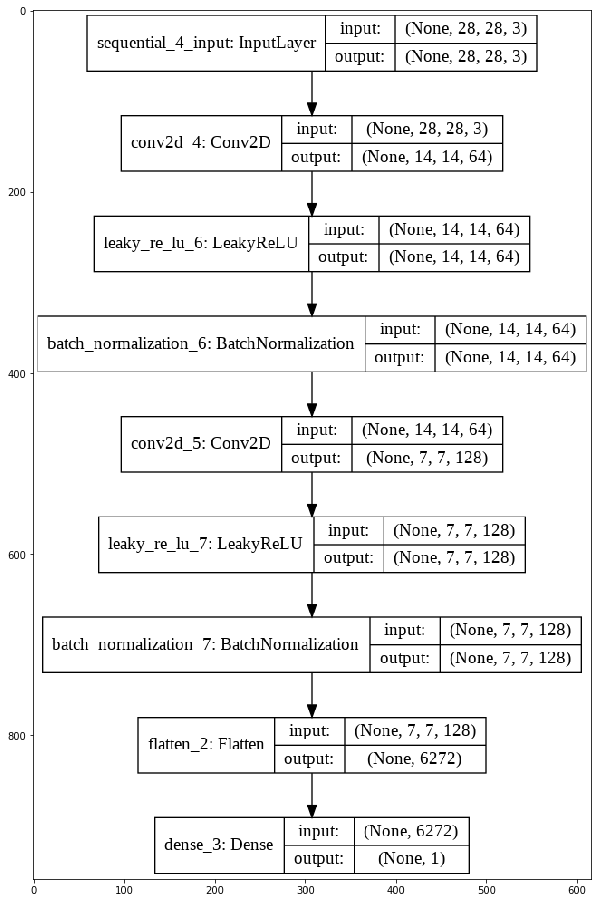

In [17]:


d_model.summary()
plot_model(d_model, to_file='dis_plot.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('dis_plot.png')
fig = plt.figure(figsize=(10, 18),facecolor='w') 
ax = fig.add_subplot(111)
ax.imshow(img, interpolation='nearest')
#ax.set_aspect(.01)

plt.show()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3136)              316736    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 3136)              12544     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)       

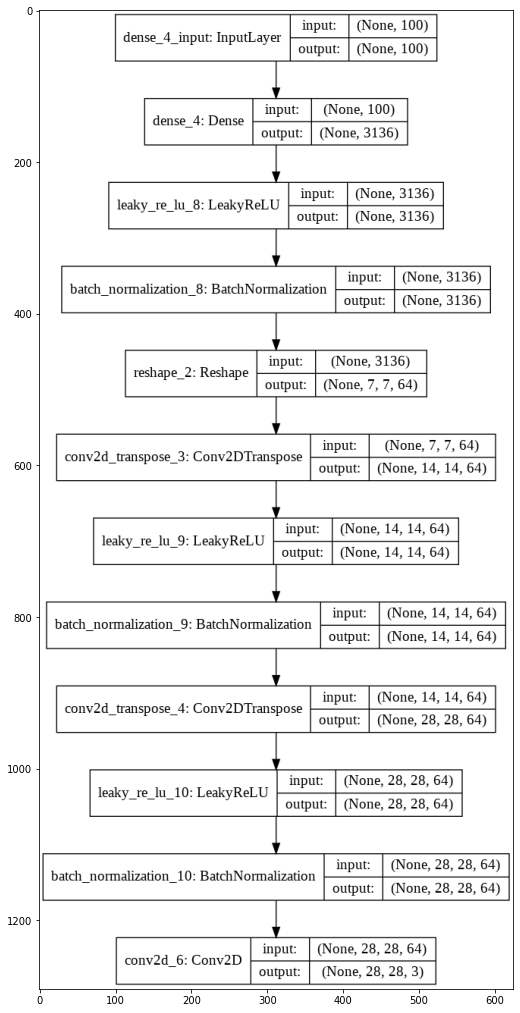

In [18]:
g_model.summary()
plot_model(g_model, to_file='gen_plot.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('gen_plot.png')
fig = plt.figure(figsize=(10, 18),facecolor='w') 
ax = fig.add_subplot(111)
ax.imshow(img) #, interpolation='nearest')
#ax.set_aspect(.01)

28
/content/drive/My Drive/Data/DCGAN/simps_28_uint8.npy
(9877, 28, 28, 3)


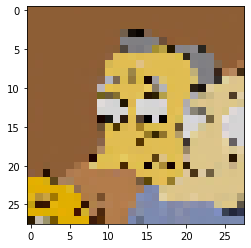

In [19]:
# size of the latent space 100
latent_dim = 100   
# create the discriminator
image_size = 28
print (str(image_size))
fileName = simps_dir + "simps_" + str(image_size) + "_uint8.npy"
print (fileName)
trainX = np.load(fileName)
plt.imshow(trainX[131])
print (trainX.shape)

  9%|▉         | 9/100 [00:19<03:12,  2.12s/it]

>Accuracy real: 89%, fake: 0%


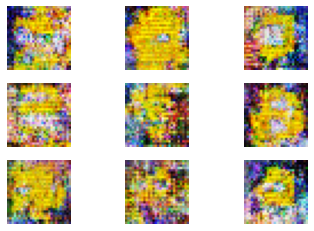

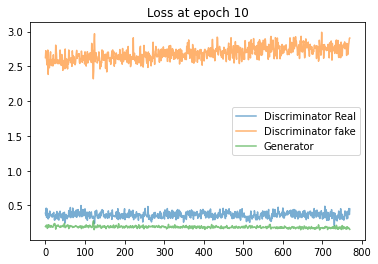

 19%|█▉        | 19/100 [00:40<02:51,  2.12s/it]

>Accuracy real: 99%, fake: 0%


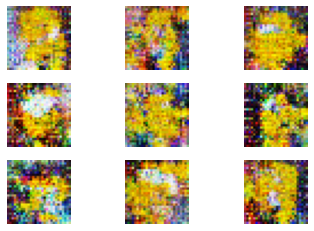

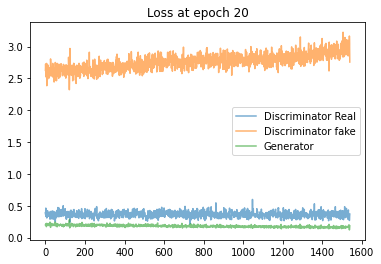

 29%|██▉       | 29/100 [01:02<02:31,  2.14s/it]

>Accuracy real: 79%, fake: 0%


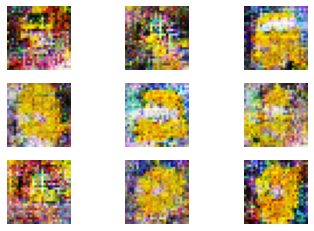

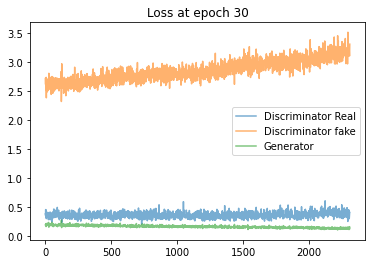

 39%|███▉      | 39/100 [01:24<02:09,  2.13s/it]

>Accuracy real: 45%, fake: 0%


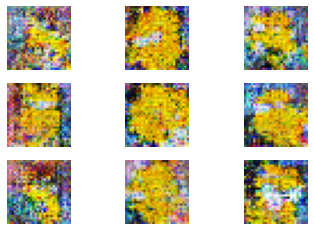

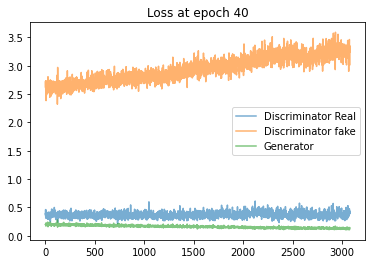

 49%|████▉     | 49/100 [01:45<01:48,  2.12s/it]

>Accuracy real: 100%, fake: 0%


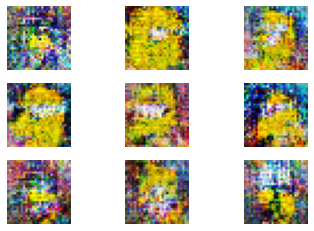

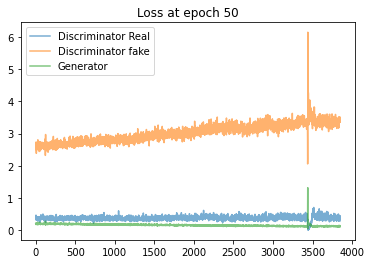

 59%|█████▉    | 59/100 [02:07<01:27,  2.13s/it]

>Accuracy real: 100%, fake: 0%


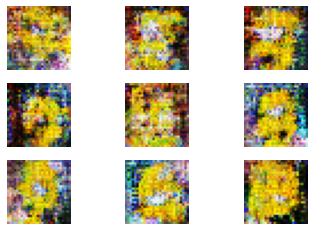

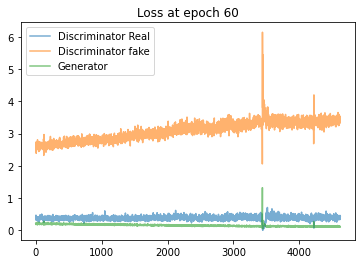

 69%|██████▉   | 69/100 [02:28<01:05,  2.12s/it]

>Accuracy real: 91%, fake: 0%


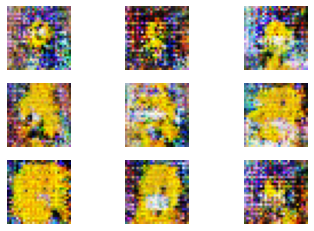

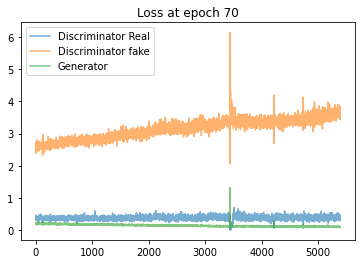

 79%|███████▉  | 79/100 [02:50<00:44,  2.12s/it]

>Accuracy real: 97%, fake: 0%


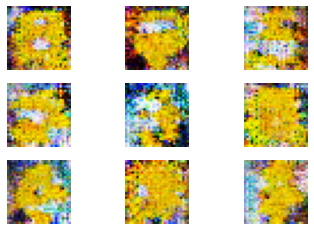

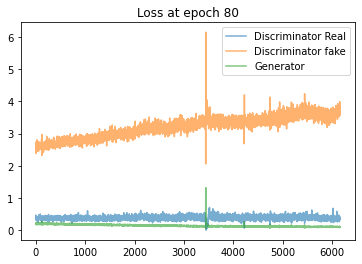

 89%|████████▉ | 89/100 [03:12<00:23,  2.12s/it]

>Accuracy real: 95%, fake: 0%


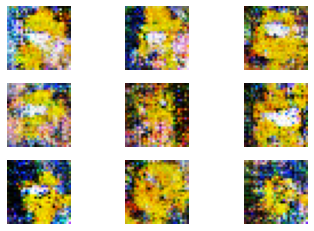

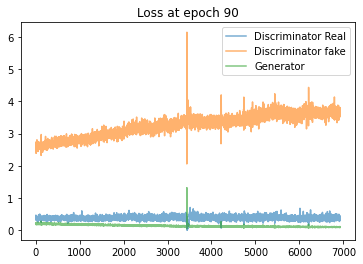

 99%|█████████▉| 99/100 [03:34<00:02,  2.13s/it]

>Accuracy real: 99%, fake: 0%


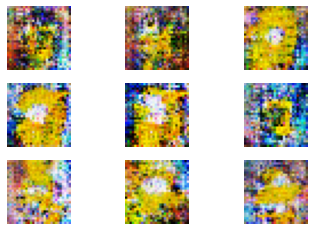

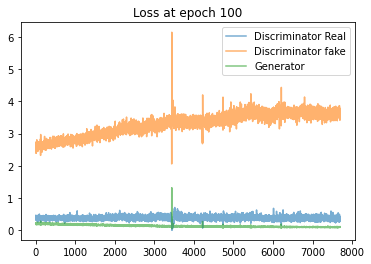

100%|██████████| 100/100 [03:36<00:00,  2.27s/it]


In [25]:
# load image data

dataset = load_real_samples_simps()
#dataset = load_real_samples_cifar10_test()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(100, 100)
0.2883746233313538


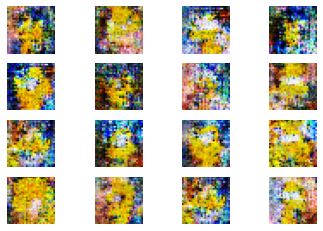

In [26]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 100)
print (latent_points.shape)
print (latent_points[0][20])
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
ix = randint(0, 100, 16)
# retrieve selected images
X = X[ix]
create_plot(X, 4)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


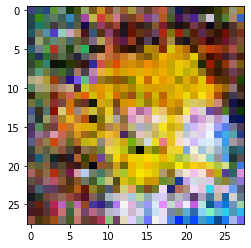

In [27]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_100.h5')
# all 0s
vector = asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()